In [60]:
import matplotlib.pyplot as plt
import numpy as np
# This just ensures some comments in dataframes below display nicely
import pandas as pd
from multihist import Hist1d, Histdd
pd.options.display.max_colwidth = 100

In [209]:
import strax
export, __all__ = strax.exporter()


In [2]:
import straxen
st = straxen.contexts.strax_workshop_dali()

In [3]:
straxen.download_test_data()

In [133]:
st.data_info('peak_basics')

,Field name,Data type,Comment
0,time,int64,Start time of the peak (ns since unix epoch)
1,endtime,int64,End time of the peak (ns since unix epoch)
2,area,float32,Peak integral in PE
3,n_channels,int16,Number of PMTs contributing to the peak
4,max_pmt,int16,PMT number which contributes the most PE
5,max_pmt_area,int32,Area of signal in the largest-contributing PMT (PE)
6,range_50p_area,float32,Width (in ns) of the central 50% area of the peak
7,area_fraction_top,float32,Fraction of area seen by the top array
8,length,int32,Length of the peak waveform in samples
9,dt,int16,Time resolution of the peak waveform in ns


In [48]:
runs = st.select_runs(run_mode='background_triggerless')['name'].values[:5]
runs

array(['180215_1029', '180216_1324', '180216_1455', '180216_1625',
       '180216_2357'], dtype=object)

In [156]:
runid = '180215_1029'

In [157]:
basics = st.get_df(runid, 'peak_basics')
arr = st.get_array(runid, 'peaks')

In [158]:
# construct an actual dataframe
peaks = pd.DataFrame(arr[['area', 'n_hits', 'time', 'length', 'n_saturated_channels', 'dt']])

In [159]:
peaks['width10'] = arr['width'][:, 1]
peaks['width20'] = arr['width'][:, 2]
peaks['width50'] = arr['width'][:, 5]
peaks['width90'] = arr['width'][:, 9]

In [160]:
basics['time_previous_peak'] = np.hstack((np.nan, basics['endtime'].values[:-1]))
basics['peak_time_diff_ns'] = basics['time'] - basics['time_previous_peak']
basics.head()

,time,endtime,area,n_channels,max_pmt,max_pmt_area,range_50p_area,area_fraction_top,length,dt,time_previous_peak,peak_time_diff_ns
0,1518690592000528700,1518690592000528930,1.058814,1,5,134,5.183753,1.0,23,10,NaN,NaN
1,1518690592007144310,1518690592007144550,0.640499,1,126,184,39.519909,1.0,24,10,1.518691e+18,6615296.0
2,1518690592007608370,1518690592007608600,0.000000,1,87,225,0.000000,0.0,23,10,1.518691e+18,463872.0
3,1518690592007618830,1518690592007619220,0.000000,1,87,275,0.000000,0.0,39,10,1.518691e+18,10240.0
4,1518690592007628210,1518690592007628420,0.000000,1,87,311,0.000000,0.0,21,10,1.518691e+18,8960.0


In [161]:
# afterpulses would only occur in a single channel
aps = basics[basics.n_channels == 1]

# afterpulses occur within ~5 microseconds
aps = aps[aps.peak_time_diff_ns/1e3 < 5]


(0, 2553.15)

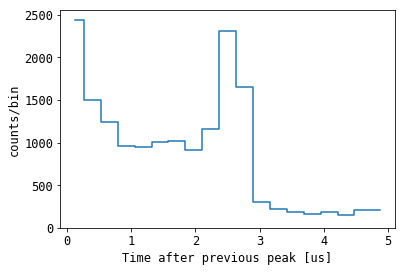

In [162]:
h = Hist1d(aps.peak_time_diff_ns/1000, bins=np.linspace(0, 5, 20))

h.plot()
plt.xlabel("Time after previous peak [us]")
plt.ylabel('counts/bin')
plt.ylim(0, )

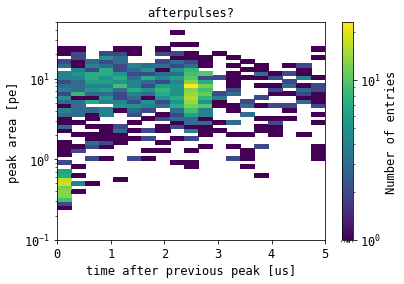

In [164]:
h = Histdd(aps.peak_time_diff_ns/1000, aps.area,
           bins=[np.linspace(0, 5, 20), np.logspace(-3, 2, 100)])
h.plot(log_scale=True)
plt.ylabel("peak area [pe]")
plt.xlabel('time after previous peak [us]')
plt.title('afterpulses?')
plt.yscale('log')
plt.ylim(0.1, 50)
plt.show()

In [171]:
# this is really slow, and not really needed
def channel_in_previous_peak(row):
    # get the time of the previous peak
    time = basics[basics['endtime'] == row['time_previous_peak']]['time'].values[0]
    apc = arr[arr['time'] == time]['area_per_channel'][0]
    return row.max_pmt in np.where(apc > 0)[0]

In [167]:
aps['channel_in_prev_peak'] = aps.apply(channel_in_previous_peak, axis=1)


In [172]:
aps2 = aps[aps.area > 0]

In [175]:
aps3 = aps2.apply(channel_in_previous_peak, axis=1)

In [176]:
print(len(aps), len(aps2), len(aps3))

16812 1046 1046


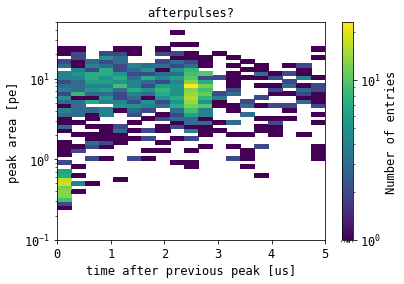

In [177]:
h = Histdd(aps2.peak_time_diff_ns/1000, aps2.area,
           bins=[np.linspace(0, 5, 20), np.logspace(-3, 2, 100)])
h.plot(log_scale=True)
plt.ylabel("peak area [pe]")
plt.xlabel('time after previous peak [us]')
plt.title('afterpulses?')
plt.yscale('log')
plt.ylim(0.1, 50)
plt.show()

In [224]:
@export
@strax.takes_config(
    strax.Option('s1_max_width', default=150,
                 help="Maximum (IQR) width of S1s"),
    strax.Option('s1_min_n_channels', default=3,
                 help="Minimum number of PMTs that must contribute to a S1"),
    strax.Option('s2_min_area', default=10,
                 help="Minimum area (PE) for S2s"),
    strax.Option('s2_min_width', default=200, help="Minimum width for S2s"),
    strax.Option('afterpulse_max_timediff', default=5, 
                 help='Maximum time in us after a previous peak to be considered afterpulse'))
class PeakClassification2(strax.Plugin):
    __version__ = '0.0.3'
    depends_on = ('peak_basics',)
    
    dtype = [
        ('type', np.int8, 'Classification of the peak.')]
    parallel = True

    def compute(self, peaks):
        p = peaks
        
        # for afterpulse classification
        time_previous_peak= np.hstack((np.nan, p['endtime'][:-1]))
        peak_time_diff_ns = p['time'] - time_previous_peak
        
        r = np.zeros(len(p), dtype=self.dtype)

        is_s1 = p['n_channels'] >= self.config['s1_min_n_channels']
        is_s1 &= p['range_50p_area'] < self.config['s1_max_width']
        r['type'][is_s1] = 1

        is_s2 = p['area'] > self.config['s2_min_area']
        is_s2 &= p['range_50p_area'] > self.config['s2_min_width']
        r['type'][is_s2] = 2
        
        is_ap = p['n_channels'] == 1
        is_ap &= peak_time_diff_ns/1e3 < self.config['afterpulse_max_timediff']
        r['type'][is_ap] = 3
    
        return r

In [225]:
st = straxen.contexts.strax_workshop_dali()
st.register(PeakClassification2)

__main__.PeakClassification2

In [226]:
st.data_info('peak_classification2')

,Field name,Data type,Comment
0,type,int8,Classification of the peak.


In [228]:
df = st.get_df(runid , 'peak_classification2')

In [229]:
df.head()

,type
0,0
1,0
2,0
3,0
4,0
